In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./data/augmented_data.csv")

In [3]:
data = data[["period", "minute", "second", "possession", "duration", "season_id", "match_id", "timestamp", "team", "play_pattern", "position", "location_x", "location_y", "technique", "body_part", "type", "first_time", "open_goal", "one_on_one", "aerial_won", "follows_dribble", "under_pressure", "end_location_x", "end_location_y", "goalkeeper_x", "goalkeeper_y", "statsbomb_xg", "is_goal"]]
data.nunique()

period                 5
minute               139
second                60
possession           290
duration           77925
season_id             41
match_id            3312
timestamp          82726
team                 288
play_pattern           9
position              25
location_x           635
location_y           701
technique              7
body_part              4
type                   5
first_time             2
open_goal              2
one_on_one             2
aerial_won             2
follows_dribble        2
under_pressure         2
end_location_x       375
end_location_y       704
goalkeeper_x         258
goalkeeper_y         355
statsbomb_xg       82417
is_goal                2
dtype: int64

In [4]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "duration", "end_location_x", "end_location_y", "season_id", "match_id", "timestamp", "team", "body_part", "under_pressure", "play_pattern", "technique", "position", "body_part", "type"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

location_x         0.034134
goalkeeper_x       0.027752
location_y         0.023931
goalkeeper_y       0.021958
open_goal          0.011181
period             0.008337
first_time         0.006655
one_on_one         0.004589
minute             0.003112
aerial_won         0.001199
second             0.000424
possession         0.000000
follows_dribble    0.000000
dtype: float64

In [5]:
# drop features that leak target information
data.drop(["end_location_x", "end_location_y", "duration", "season_id", "match_id", "timestamp", "team"], axis=1, inplace=True)
# drop low information features
data.drop(["period", "minute", "second", "possession"], axis=1, inplace=True)
# drop penalties
data = data[data["type"] != "Penalty"]

In [6]:
data.nunique()

play_pattern           9
position              25
location_x           635
location_y           701
technique              7
body_part              4
type                   4
first_time             2
open_goal              2
one_on_one             2
aerial_won             2
follows_dribble        2
under_pressure         2
goalkeeper_x         258
goalkeeper_y         355
statsbomb_xg       82416
is_goal                2
dtype: int64

In [7]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "body_part", "type", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [8]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [9]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal"], axis=1)

In [10]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [11]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.2).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [12]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [13]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [14]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [15]:
def logistic_regression():
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression")

    return logistic_r.predict_proba(X_test)

In [16]:
def decision_tree():
    dt = DecisionTreeClassifier(criterion="gini", max_depth=8, max_leaf_nodes=100, min_samples_split=100)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)

    calculate_stats(y_test, y_pred, "Decision Tree")

    viz_model = dtreeviz.model(dt,
                           X_train=X_train, y_train=y_train,
                           feature_names=X.columns, target_name="is_goal", class_names=["Not a goal", "Goal"])

    return dt.predict_proba(X_test), viz_model

In [17]:
def gradient_boosted_tree():
    gbt = GradientBoostingClassifier(learning_rate=0.1, max_depth=8, min_samples_split=100, n_estimators=100, max_features=None)
    gbt.fit(X_train, y_train)
    y_pred = gbt.predict(X_test)

    calculate_stats(y_test, y_pred, "Gradient Boosted Tree")

    return gbt.predict_proba(X_test)

In [18]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.05516664763528338
Root Mean Squared Error: 0.08831300449655739
R-squared (R2 Score): 0.49067577424361253


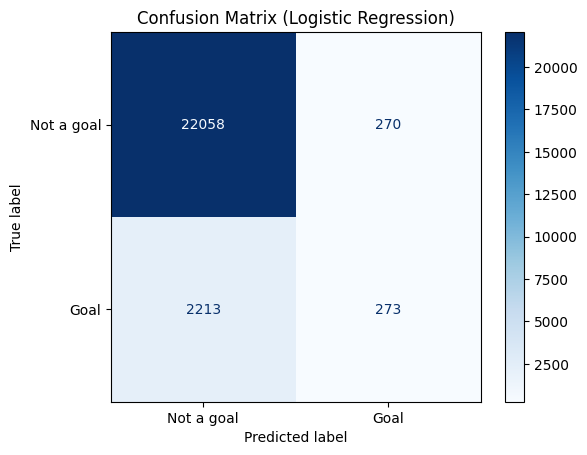


Logistic Regression
Accuracy: 0.8999355202708149
Precision: 0.5027624309392266
Recall: 0.10981496379726469
F1: 0.18025751072961374


In [19]:
X_train, X_test, y_train, y_test = preprocess_classifier(X, y2)
lor_xg = logistic_regression()

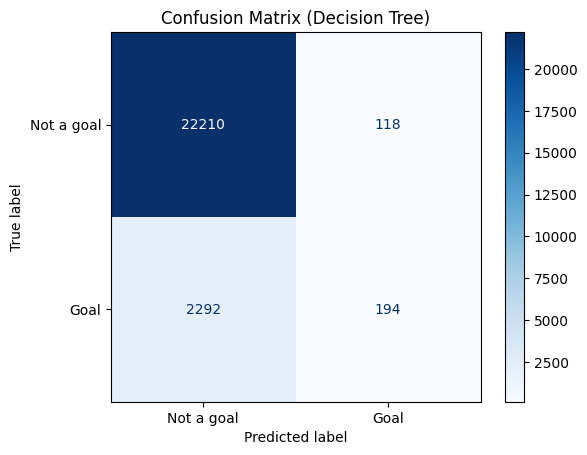


Decision Tree
Accuracy: 0.9028774079148868
Precision: 0.6217948717948718
Recall: 0.07803700724054706
F1: 0.13867047891350964


In [20]:
dt_xg, viz = decision_tree()

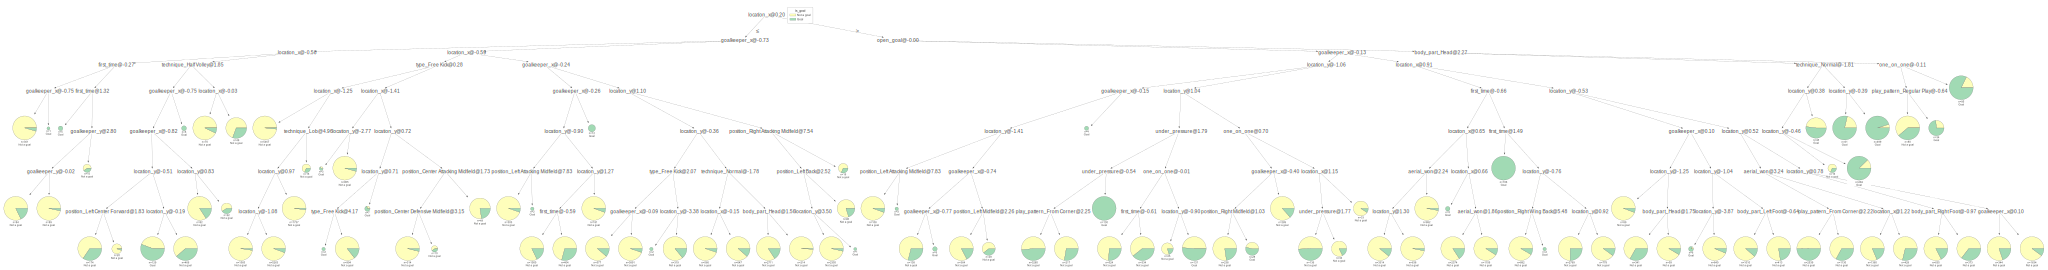

In [21]:
viz.view(fancy=False)

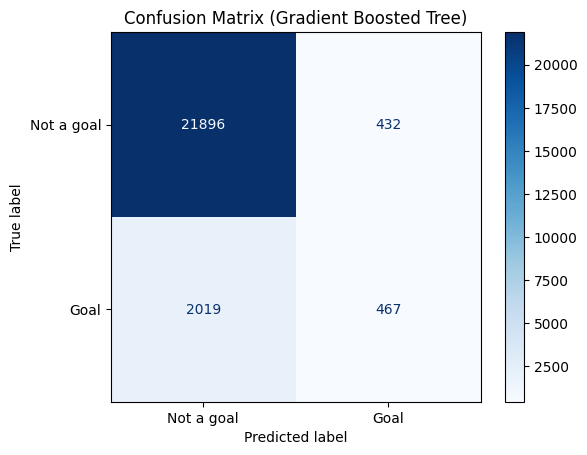


Gradient Boosted Tree
Accuracy: 0.9012251148545176
Precision: 0.5194660734149055
Recall: 0.18785197103781173
F1: 0.2759231905465288


In [22]:
gbt_xg = gradient_boosted_tree()

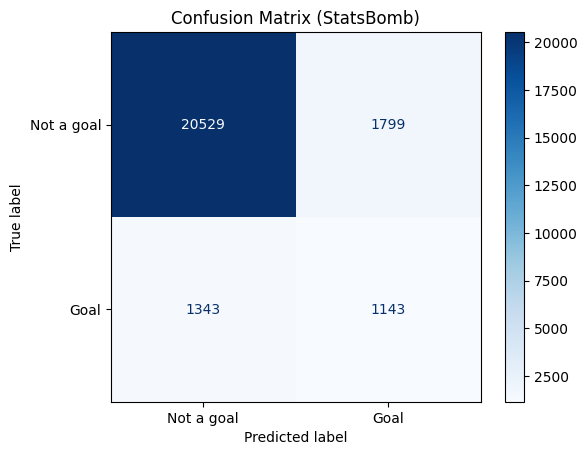


StatsBomb
Accuracy: 0.8733779318126864
Precision: 0.3885112168592794
Recall: 0.4597747385358005
F1: 0.42114959469417834


In [23]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
_, X_temp, _, sb_xg = preprocess_continuous(X, y1)
sb_pred = sb_xg.apply(lambda x: math.ceil(x-0.25))
calculate_stats(y_test, sb_pred, "StatsBomb")

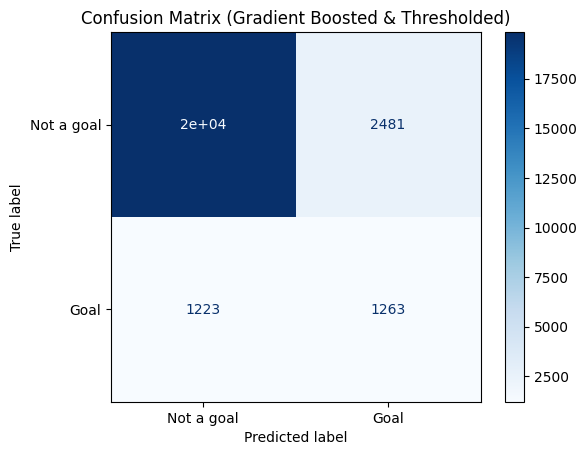


Gradient Boosted & Thresholded
Accuracy: 0.8507294269364069
Precision: 0.3373397435897436
Recall: 0.5080450522928399
F1: 0.40545746388443016


In [24]:
# empirically, the statsbomb predictions maximise f1 score at threshold=0.15, precision at threshold=1, recall at threshold=0, and accuracy at threshold=20
gbt_pred = [math.ceil(x[1]-0.25) for x in gbt_xg]
calculate_stats(y_test, gbt_pred, "Gradient Boosted & Thresholded")

In [25]:
df = pd.DataFrame({"lr_xg": lr_xg, "lor_xg": [x[1] for x in lor_xg], "dt_xg": [x[1] for x in dt_xg], "gbt_xg": [x[1] for x in gbt_xg], "sxg": sb_xg})
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lr_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["lor_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["dt_xg"]), np.asarray(df["sxg"]))))
pprint(pd.DataFrame(np.corrcoef(np.asarray(df["gbt_xg"]), np.asarray(df["sxg"]))))

          0         1
0  1.000000  0.700491
1  0.700491  1.000000
          0         1
0  1.000000  0.692168
1  0.692168  1.000000
          0         1
0  1.000000  0.784688
1  0.784688  1.000000
          0         1
0  1.000000  0.855025
1  0.855025  1.000000


In [26]:
diff = gbt_pred - y_test
data_copy.iloc[diff[diff == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,second,possession,duration,season_id,match_id,timestamp,team,play_pattern,...,one_on_one,aerial_won,follows_dribble,under_pressure,end_location_x,end_location_y,goalkeeper_x,goalkeeper_y,statsbomb_xg,is_goal
41198,2.0,81.0,4.0,151.0,2.456509,2021/2022,3817886.0,00:36:04.314,Kerala Blasters,From Throw In,...,False,False,False,False,120.0,36.7,109.3,38.4,0.003525,True
7482,1.0,34.0,57.0,93.0,3.394190,2018/2019,19810.0,00:34:57.530,Bristol City WFC,From Free Kick,...,False,False,False,False,120.0,37.0,119.0,40.3,0.005006,True
77163,1.0,47.0,11.0,107.0,1.816030,2015/2016,3900538.0,00:47:11.667,Guingamp,From Free Kick,...,False,False,False,False,120.0,41.4,116.2,40.1,0.005248,True
75940,1.0,49.0,18.0,90.0,2.868910,2023,3893829.0,00:49:18.772,France Women's,From Corner,...,False,False,False,False,120.0,43.5,117.1,39.3,0.005434,True
62636,2.0,63.0,1.0,165.0,1.796333,2015/2016,3879742.0,00:18:01.574,AC Milan,Regular Play,...,False,False,False,False,120.0,42.5,116.2,40.8,0.005512,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64087,2.0,63.0,34.0,136.0,0.539689,2015/2016,3879799.0,00:18:34.292,AS Roma,From Free Kick,...,False,False,False,False,120.0,43.0,117.2,36.7,0.424192,True
20598,1.0,33.0,28.0,80.0,0.959754,2019/2020,2275102.0,00:33:28.522,Brighton & Hove Albion WFC,From Counter,...,False,False,False,False,120.0,41.4,111.9,44.1,0.426328,True
75912,2.0,76.0,3.0,130.0,0.952498,2023,3893828.0,00:31:03.785,England Women's,From Counter,...,False,False,False,True,120.0,38.8,107.5,56.9,0.445950,True
17051,1.0,26.0,32.0,50.0,1.265912,2012/2013,266827.0,00:26:32.995,Barcelona,From Keeper,...,False,False,False,False,120.0,37.3,106.8,27.0,0.498386,True


In [27]:
diff_sb = sb_pred - y_test
data_copy.iloc[diff_sb[diff_sb == -1].index].sort_values(by=["statsbomb_xg"])

,period,minute,second,possession,duration,season_id,match_id,timestamp,team,play_pattern,...,one_on_one,aerial_won,follows_dribble,under_pressure,end_location_x,end_location_y,goalkeeper_x,goalkeeper_y,statsbomb_xg,is_goal
75341,1.0,3.0,35.0,10.0,2.117102,2023,3893807.0,00:03:35.731,Republic of Ireland Women's,From Corner,...,True,False,False,False,120.0,37.2,118.1,39.8,0.000180,True
41198,2.0,81.0,4.0,151.0,2.456509,2021/2022,3817886.0,00:36:04.314,Kerala Blasters,From Throw In,...,False,False,False,False,120.0,36.7,109.3,38.4,0.003525,True
7482,1.0,34.0,57.0,93.0,3.394190,2018/2019,19810.0,00:34:57.530,Bristol City WFC,From Free Kick,...,False,False,False,False,120.0,37.0,119.0,40.3,0.005006,True
77163,1.0,47.0,11.0,107.0,1.816030,2015/2016,3900538.0,00:47:11.667,Guingamp,From Free Kick,...,False,False,False,False,120.0,41.4,116.2,40.1,0.005248,True
75940,1.0,49.0,18.0,90.0,2.868910,2023,3893829.0,00:49:18.772,France Women's,From Corner,...,False,False,False,False,120.0,43.5,117.1,39.3,0.005434,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38070,1.0,5.0,10.0,12.0,0.734094,2021/2022,3802665.0,00:05:10.563,Paris Saint-Germain,From Corner,...,False,False,False,False,120.0,42.9,116.9,37.4,0.198835,True
49710,2.0,75.0,39.0,167.0,0.410141,2015/2016,3825895.0,00:30:39.213,Las Palmas,From Throw In,...,False,False,False,False,120.0,38.5,119.0,40.1,0.199092,True
49392,1.0,25.0,52.0,61.0,1.102393,2015/2016,3825883.0,00:25:52.817,Málaga,Regular Play,...,True,False,False,False,120.0,37.0,117.8,40.9,0.199271,True
38169,2.0,91.0,23.0,182.0,0.546392,2021/2022,3802685.0,00:46:23.391,Paris Saint-Germain,From Free Kick,...,True,False,False,False,120.0,36.6,117.7,40.1,0.199503,True


In [28]:
_, data_copy_test, _, gbt_xg_test = train_test_split(data_copy[data_copy["type"] != "Penalty"], y2, test_size=0.3, random_state=20)
diff_xg = [x[1] for x in gbt_xg] - sb_xg
data_copy_test["diff"] = diff_xg
data_copy_test["gbt_xg"] = [x[1] for x in gbt_xg]
data_copy_test["sb_xg"] = sb_xg
data_copy_test.sort_values(by=["diff"])

,period,minute,second,possession,duration,season_id,match_id,timestamp,team,play_pattern,...,under_pressure,end_location_x,end_location_y,goalkeeper_x,goalkeeper_y,statsbomb_xg,is_goal,diff,gbt_xg,sb_xg
64093,2.0,74.0,19.0,153.0,0.459405,2015/2016,3879799.0,00:29:19.889,Lazio,From Corner,...,False,120.0,37.2,113.8,51.9,0.954583,True,-0.715935,0.238649,0.954583
35369,1.0,15.0,25.0,36.0,0.733023,2020/2021,3775606.0,00:15:25.052,Chelsea FCW,From Counter,...,True,120.0,38.8,106.1,32.7,0.942560,True,-0.618237,0.324324,0.942560
8780,2.0,65.0,0.0,144.0,0.139073,2005/2006,68321.0,00:20:00.742,Barcelona,From Corner,...,False,120.0,38.2,119.2,37.5,0.864461,True,-0.586143,0.278318,0.864461
31465,2.0,73.0,53.0,136.0,0.830409,2015/2016,3754307.0,00:28:53.517,Manchester City,From Corner,...,False,120.0,37.4,104.5,34.9,0.929620,True,-0.492560,0.437060,0.929620
80507,2.0,73.0,17.0,159.0,0.551704,2015/2016,3901188.0,00:28:17.478,Saint-Étienne,From Throw In,...,True,120.0,43.3,115.0,42.3,0.866330,True,-0.463625,0.402705,0.866330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51033,1.0,23.0,37.0,42.0,1.396438,2015/2016,3829452.0,00:23:37.851,Bordeaux,From Corner,...,False,120.0,38.7,118.5,39.3,0.000180,False,0.712948,0.713128,0.000180
43059,1.0,6.0,20.0,17.0,2.253122,2015/2016,3825616.0,00:06:20.648,Málaga,From Keeper,...,False,120.0,36.7,-1.0,-1.0,0.142489,True,0.734376,0.876865,0.142489
8760,1.0,3.0,31.0,12.0,1.126500,2005/2006,68321.0,00:03:31.132,Barcelona,From Corner,...,False,120.0,35.7,119.0,40.3,0.000180,False,0.742011,0.742191,0.000180
71704,1.0,17.0,23.0,38.0,1.609954,2015/2016,3890441.0,00:17:23.873,VfB Stuttgart,From Corner,...,False,120.0,42.9,119.1,39.1,0.000180,False,0.755275,0.755455,0.000180


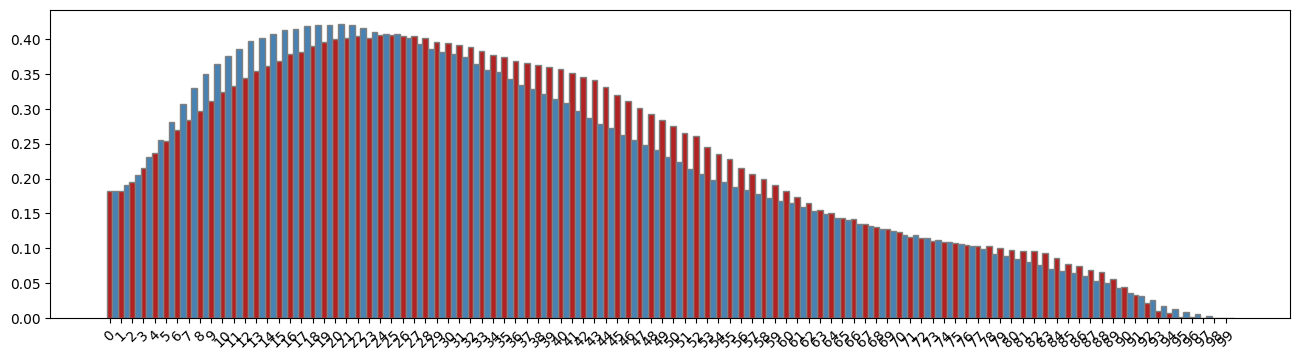

In [29]:
my_f1_scores = []
sb_f1_scores = []
for threshold in range(0, 100):
    gbt_pred = [math.ceil(x[1]-(threshold/100)) for x in gbt_xg]
    sb_pred = [math.ceil(x-(threshold/100)) for x in sb_xg]
    my_f1 = f1_score(y_test, gbt_pred)
    sb_f1 = f1_score(y_test, sb_pred)
    my_f1_scores.append(my_f1)
    sb_f1_scores.append(sb_f1)

barWidth = 0.5
r1 = np.arange(len(my_f1_scores))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(16,4))
plt.bar(r1, pd.Series(my_f1_scores), color="firebrick", width=barWidth, edgecolor='grey', label='Our Prediction')
plt.bar(r2, pd.Series(sb_f1_scores), color="steelblue", width=barWidth, edgecolor='grey', label='SB Prediction')

plt.xticks(r1, [x for x in range(0, 100)], rotation=45)
plt.show()